# Knowledge Distillation of a Neural Network
Demonstration of the Knowledge Distillation method on MNIST data
- Train an **"expensive"** and **large** model on MNIST data to achieve a good generalization performance. This is the **teacher** model.
- Create a much **cheaper and smaller** model but instead of using the actual labels, it uses the predictions of the teacher model on training data. These are the **soft labels** and this model is called **student**
- Compare its performance with the same model trained on actual labels. It turns out that the student model performs much better on generalizing on test data

In [2]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score, KFold

import utils

## MNIST data

In [5]:
mnist = tf.keras.datasets.mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

X_train = X_train / 255.0
X_test = X_test / 255.0

# Add a channels dimension
X_train = X_train[..., tf.newaxis].astype("float32")
X_test = X_test[..., tf.newaxis].astype("float32")

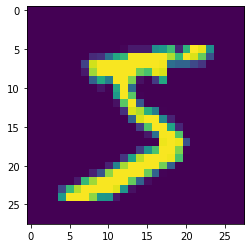

In [6]:
plt.imshow(X_train[0, :, :, 0])

In [7]:
num_train = X_train.shape[0]
num_test = X_test.shape[0]
num_train, num_test

(60000, 10000)

In [8]:
tf.random.set_seed(0)

## Teacher Model
Train a large and compute-intensive model that uses Dropout and generalizes well on test data.  
Here by "large" we mean a wide neural network with convolution filters and 2 fully-connected hidden layers.  

In [7]:
class TeacherModel(Model):
    def __init__(self, T: float):
        super(TeacherModel, self).__init__()
        
        self.T = T
        
        self.conv1 = Conv2D(32, 3, activation="relu")
        self.flatten = Flatten()
        
        self.d1 = Dense(1200, activation="relu")
        self.d2 = Dense(1200, activation="relu")
        self.d3 = Dense(10)
        
        self.dropout_layer_hidden = tf.keras.layers.Dropout(rate=0.5)
        
        self.output_layer = tf.keras.layers.Softmax()

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        
        x = self.d1(x)
        x = self.dropout_layer_hidden(x)
        
        x = self.d2(x)
        x = self.dropout_layer_hidden(x)
        
        x = self.d3(x)
        x = self.output_layer(x / self.T)
        return x

In [8]:
T = 3.5  # Softmax temperature
teacher = TeacherModel(T=T)

### Train teacher model

In [9]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

teacher.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=["accuracy"])

In [10]:
num_epochs = 1
batch_size = 32

teacher.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_split=0.2)

1500/1500 [==============================] - 238s 159ms/step - loss: 0.1935 - accuracy: 0.9381 - val_loss: 0.0783 - val_accuracy: 0.9748


### Evaluate generalization of teacher model

In [11]:
y_pred_teacher = np.argmax(teacher(X_test), axis=1)

In [12]:
acc = accuracy_score(y_test, y_pred_teacher)
acc

0.9752

In [13]:
int((1 - acc) * num_test)

248

The teacher model achieved **248 test errors**

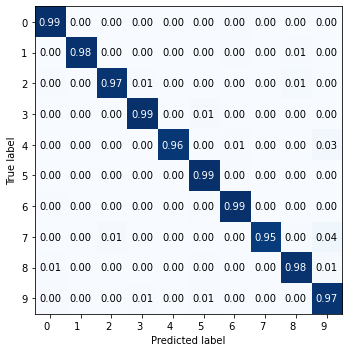

In [14]:
utils.plot_confusion_matrix(y_test, y_pred_teacher, classes=list(range(10)), normalize=True)
plt.show()

### Calculate teacher predictions on train set as well
These will be later used for training the student model

In [15]:
y_train_pred_teacher = teacher(X_train)

## Student model
A much smaller and shallow neural network is used as the student model.

In [20]:
class StudentModel(Model):
    def __init__(self, T):
        super(StudentModel, self).__init__()
        
        self.T = T
        
        self.input_layer = tf.keras.layers.Flatten(input_shape=(28, 28))
        self.d1 = Dense(10, activation="relu")
        self.d2 = Dense(10)
        self.output_layer = tf.keras.layers.Softmax()

    def call(self, x):
        x = self.input_layer(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.output_layer(x / self.T)
        return x

## Train small model on original labels

First we will train the small model on original labels and evaluate its performance on generalizing on test data.  
We expect that its performance will be worse than the teacher model since it has far less parameters

In [24]:
small_model = StudentModel(T=1.0)

In [25]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

small_model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=["accuracy"])

In [26]:
num_epochs = 3
batch_size = 32

cv = 3
scores = np.zeros(cv)
kf = KFold(n_splits=cv)
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    X_train_kf, X_test_kf = X_train[train_index], X_train[test_index]
    y_train_kf, y_test_kf = y_train[train_index], y_train[test_index]

    small_model.fit(X_train_kf, y_train_kf, batch_size=batch_size, epochs=num_epochs, verbose=0)
    y_pred = small_model.predict(X_test_kf)
    y_pred = np.argmax(y_pred, axis=1)

    score = accuracy_score(y_test_kf, y_pred)
    scores[i] = score

    print(f"Fold: {i + 1}, accuracy: {score}")

Fold: 1, accuracy: 0.84905
Fold: 2, accuracy: 0.85485
Fold: 3, accuracy: 0.86305


In [27]:
scores.mean()

0.8556499999999999

In [28]:
small_model.fit(X_train, y_train, batch_size=batch_size, epochs=num_epochs, verbose=0)
y_pred_small = np.argmax(small_model.predict(X_test), axis=1)

In [29]:
acc = accuracy_score(y_test, y_pred_small)
acc

0.8634

In [30]:
int((1 - acc)*num_test)

1366

The small model trained on original labels achieved **1366 test errors**

## Distill knowledge of the big teacher model to the small student model

In [58]:
student_model = StudentModel(T=3.5)

In [59]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy()

student_model.compile(
    loss=loss,
    optimizer=optimizer,
    metrics=["accuracy"])

In [60]:
num_epochs = 3
batch_size = 32

cv = 3
scores = np.zeros(cv)
kf = KFold(n_splits=cv)
for i, (train_index, test_index) in enumerate(kf.split(X_train)):
    X_train_kf, X_test_kf = X_train[train_index], X_train[test_index]
    y_train_kf, y_test_kf = y_train_pred_teacher.numpy()[train_index], y_train_pred_teacher.numpy()[test_index]

    student_model.fit(X_train_kf, y_train_kf, batch_size=batch_size, epochs=num_epochs, verbose=0)
    y_pred = student_model.predict(X_test_kf)
    y_pred = np.argmax(y_pred, axis=1)

    score = accuracy_score(np.argmax(y_test_kf, axis=1), y_pred)
    scores[i] = score

    print(f"Fold: {i + 1}, accuracy: {score}")

Fold: 1, accuracy: 0.9148
Fold: 2, accuracy: 0.9235
Fold: 3, accuracy: 0.9332


In [61]:
scores.mean()

0.9238333333333332

In [62]:
student_model.fit(X_train, y_train_pred_teacher, batch_size=batch_size, epochs=num_epochs, verbose=0)
y_pred_student = np.argmax(student_model(X_test), axis=1)

In [63]:
acc = accuracy_score(y_test, y_pred_student)
acc

0.9303

In [64]:
int((1 - acc)*num_test)

696

The distilled model trained on soft labels achieved **696 test errors**, **50% fewer errors than the same model trained on raw labels**